# **Insurance Cost Analysis**

| Parameter |Description| Content type |
|---|----|---|
|age| Age in years| integer |
|gender| Male or Female|integer (1 or 2)|
| bmi | Body mass index | float |
|no_of_children| Number of children | integer|
|smoker| Whether smoker or not | integer (0 or 1)|
|region| Which US region - NW, NE, SW, SE | integer (1,2,3 or 4 respectively)| 
|charges| Annual Insurance charges in USD | float|


In [6]:
import micropip
await micropip.install("seaborn")

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

In [8]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

In [9]:
filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'

In [10]:
await download(filepath, "insurance.csv")
file_name="insurance.csv"

In [11]:
df = pd.read_csv(file_name)

In [13]:
df = pd.read_csv(file_name, header = None)
df.head(10)

,0,1,2,3,4,5,6
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520
5,31,1,25.740,0,?,4,3756.62160
6,46,1,33.440,1,0,4,8240.58960
7,37,1,27.740,3,0,1,7281.50560
8,37,2,29.830,2,0,2,6406.41070
9,60,1,25.840,0,0,1,28923.13692


In [14]:
headers = ["age", "gender", "bmi", "no_of_children", "smoker", "region", "charges"]
df.columns = headers

In [15]:
df.replace("?",np.NaN, inplace = True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2768 non-null   object 
 1   gender          2772 non-null   int64  
 2   bmi             2772 non-null   float64
 3   no_of_children  2772 non-null   int64  
 4   smoker          2765 non-null   object 
 5   region          2772 non-null   int64  
 6   charges         2772 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 130.0+ KB


In [18]:
# Replace NaN in 'age' column with the mean age
mean_age = df["age"].astype("float").mean()
df.loc[:, "age"] = df["age"].astype("float").fillna(mean_age)

# Replace NaN in 'smoker' column with the most frequent value
is_smoker = df["smoker"].mode()[0]
df.loc[:, "smoker"] = df["smoker"].fillna(is_smoker)

# Convert both columns to int (if safe to do so)
df["age"] = df["age"].astype(int)
df["smoker"] = df["smoker"].astype(int)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2772 non-null   int32  
 1   gender          2772 non-null   int64  
 2   bmi             2772 non-null   float64
 3   no_of_children  2772 non-null   int64  
 4   smoker          2772 non-null   int32  
 5   region          2772 non-null   int64  
 6   charges         2772 non-null   float64
dtypes: float64(2), int32(2), int64(3)
memory usage: 130.0 KB


In [19]:
df["charges"] = np.round(df["charges"], 2)
df.head(5)

,age,gender,bmi,no_of_children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92
1,18,2,33.770,1,0,4,1725.55
2,28,2,33.000,3,0,4,4449.46
3,33,2,22.705,0,0,1,21984.47
4,32,2,28.880,0,0,1,3866.86


(0.0, 66902.85800000001)

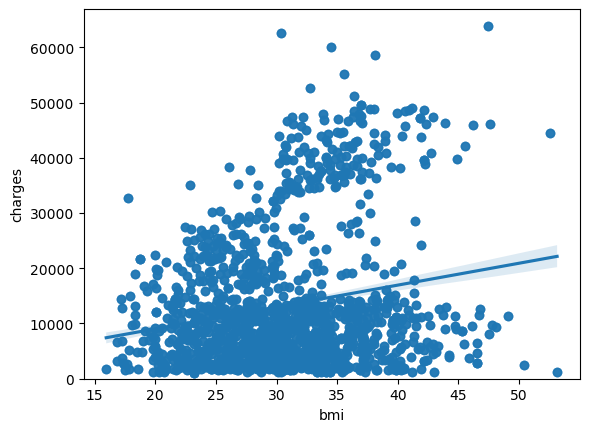

In [20]:
sns.regplot(x = "bmi", y= "charges", data = df)
plt.ylim(0,)

<AxesSubplot:xlabel='smoker', ylabel='charges'>

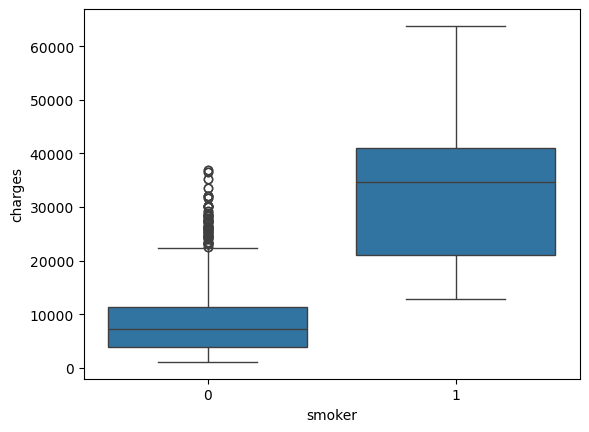

In [21]:
sns.boxplot( x="smoker" , y="charges", data = df)

In [22]:
df.corr()

,age,gender,bmi,no_of_children,smoker,region,charges
age,1.000000,-0.026046,0.113048,0.037574,-0.023286,-0.007167,0.298624
gender,-0.026046,1.000000,0.042924,0.016020,0.082326,0.022213,0.062837
bmi,0.113048,0.042924,1.000000,-0.001492,0.011489,0.271119,0.199846
no_of_children,0.037574,0.016020,-0.001492,1.000000,0.006362,-0.025717,0.066442
smoker,-0.023286,0.082326,0.011489,0.006362,1.000000,0.054077,0.788783
region,-0.007167,0.022213,0.271119,-0.025717,0.054077,1.000000,0.054058
charges,0.298624,0.062837,0.199846,0.066442,0.788783,0.054058,1.000000


In [24]:
lrm = LinearRegression()
x = df[["smoker"]]
y = df["charges"]
lrm.fit(x,y)
print(lrm.score(x,y)) #value of R^2

0.6221791733924185


In [25]:
# definition of Y and lm remain same as used in last cell. 
z = df[["age", "gender", "bmi", "no_of_children", "smoker", "region"]]
lrm.fit(z,y)
print(lrm.score(z, y))

0.7504083820289634


In [26]:
Input = [("scale",StandardScaler()), ("Polynomial", PolynomialFeatures(include_bias = False)), ("model", LinearRegression())]
pipe = Pipeline(Input)
z = z.astype(float)
pipe.fit(z,y)
ypipe = pipe.predict(z)


print(r2_score(y,ypipe))

0.8451876102882967


In [27]:
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size = 0.2, random_state = 1)

In [28]:
RidgeModel = Ridge(alpha = 0.1)
RidgeModel.fit(x_train, y_train)
yhat = RidgeModel.predict(x_test)
print(r2_score(y_test, yhat))

0.6760807731582404


In [29]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
RidgeModel.fit(x_train_pr, y_train)
y_hat = RidgeModel.predict(x_test_pr)
print(r2_score(y_test,y_hat))

0.7835631107608061
